# AI based resource scaling

## Case scenario

You and your team have been assigned to a project. The business idea is to reduce carbon footprint by saving resources. Your initial investigation shows, that majority of applications that are deployed on Cloud have high and low traffic hours, but the resources are set to support the peak times. That means there are hours when the allocated resources to the application are not utilized.

You want to develop a model which will allow automatic scaling of these resources. For that purpose, your machine learning model should correctly predict the CPU usage.

## Data

The extract of the data for a sample application was provided to you. In the `data` folder you will find 2 files: `train.csv` and `test.csv`. You should conduct your exploration and model building on the `train.csv` file.
Once you are happy with the model, use the `test.csv` file to predict the `cpu_usage`. You should store your predictions in a new csv file which will be called `<your_name>.csv`. The new file should have the following attributes:
- `id` column
- `timestamp` column
- `cpu_usage` column which should hold your predictions

### Data explanation

- `id` - identifier of the record
- `timestamp` - timestamp in the format YYYY-MM-DD HH-MM-SS
- `number_of_requests` - number of requests the application received in the given time
- `number_of_errors` - number of errors that the application logged in the given time
- `response_time` - cummulative time the application took to respond to a request, in miliseconds
- `cpu_cores` - number of CPU cores allocated to the application at a given time (maximum 8 are available)
- `memory_usage` - memory allocation in a given time, in percent
- `cpu_usage` - cpu allocation in a given time, in percent

## Your delivery

At the end of the day, you should provide us with your code in which you demonstrate that you followed these steps:
1. Data load
2. Data cleaning
3. Data Exploration
4. Data Modeling and validation
5. Prediction

The submission should be done as a pull request (PR) on github to this repository. **Please use branch with your name (not main branch)**. The PR should contain the `<your_name>.csv` file stored in the `data` folder and your code stored either in a jupyter notebook or python module.
We have prepared this notebook to help you with the exercise however you are not obliged to use it.

### IMPORTS

In [70]:
import pandas as pd 
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
from xgboost import XGBRegressor


from sklearn.metrics import mean_squared_error,mean_absolute_error 
from sklearn.metrics import mean_absolute_percentage_error


from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

### LOADING DATA 

In [3]:
train = pd.read_csv('train.csv',parse_dates = True)
test =  pd.read_csv('test.csv',parse_dates = True)

### Data exploration 

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51601 entries, 0 to 51600
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  51601 non-null  int64  
 1   timestamp           51601 non-null  object 
 2   number_of_requests  51601 non-null  int64  
 3   number_of_errors    51601 non-null  float64
 4   response_time       51601 non-null  float64
 5   cpu_cores           51601 non-null  int64  
 6   memory_usage        51601 non-null  float64
 7   cpu_usage           51601 non-null  float64
dtypes: float64(4), int64(3), object(1)
memory usage: 3.1+ MB


In [5]:
train.shape

(51601, 8)

In [6]:
train.head(20)

,id,timestamp,number_of_requests,number_of_errors,response_time,cpu_cores,memory_usage,cpu_usage
0,0,2022-01-22 17:12:22,9758,0.0,14742.755324,6,0.347599,48.498589
1,1,2022-01-22 17:12:27,9967,2.0,14897.201621,6,0.756413,53.355349
2,2,2022-01-22 17:12:32,5210,1.0,14009.132817,6,0.698468,46.573140
3,3,2022-01-22 17:12:37,7361,1.0,14716.491537,6,0.137349,46.624516
4,4,2022-01-22 17:12:42,9667,0.0,15148.657690,6,0.157933,49.455284
5,5,2022-01-22 17:12:47,9036,1.0,15018.478985,6,0.179469,50.993088
6,6,2022-01-22 17:12:52,6702,1.0,13949.745742,6,0.913810,46.829059
7,7,2022-01-22 17:12:57,8591,0.0,14187.883403,6,0.972644,49.235006
8,8,2022-01-22 17:13:02,7916,0.0,14341.466056,6,0.646286,48.021224
9,9,2022-01-22 17:13:07,8718,0.0,14522.217863,6,0.806290,47.907288


In [7]:
## finding correlection for the best features selection
train.corr(method ='pearson')

,id,number_of_requests,number_of_errors,response_time,cpu_cores,memory_usage,cpu_usage
id,1.000000,0.143198,0.038654,0.140227,0.177408,-0.002627,0.017952
number_of_requests,0.143198,1.000000,0.386609,0.730648,0.840201,0.000867,0.364691
number_of_errors,0.038654,0.386609,1.000000,0.205799,0.224862,0.007733,0.533335
response_time,0.140227,0.730648,0.205799,1.000000,0.832045,0.000957,0.183187
cpu_cores,0.177408,0.840201,0.224862,0.832045,1.000000,-0.001027,0.106763
memory_usage,-0.002627,0.000867,0.007733,0.000957,-0.001027,1.000000,0.008249
cpu_usage,0.017952,0.364691,0.533335,0.183187,0.106763,0.008249,1.000000


In [8]:
## memory_usage is not a very usefull feature in determining the cpu_usage 
## from the above it can be seen that cpu_usage is closely realated to number_of_errors and number_of_requests 
## the rest have significant low correlation i will drop memory_usage 

### Data cleaning and Data visualization

In [9]:
train_data = train.drop(['id','timestamp','memory_usage'], axis = 1)

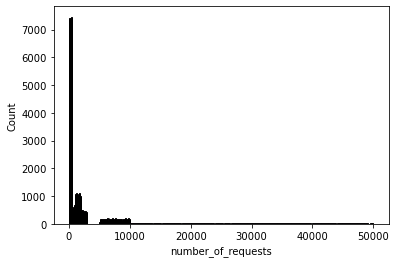

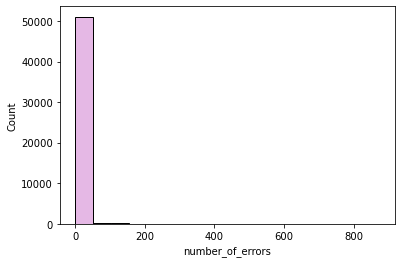

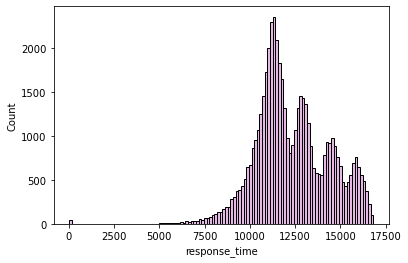

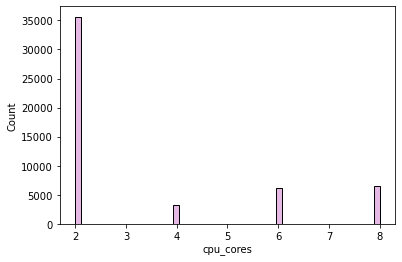

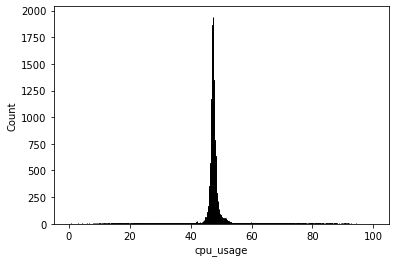

In [10]:
#data visualization
for column in train_data:
    sns.histplot(train_data[column], color='plum',  edgecolor="k", linewidth=1)
    plt.show()

#### ploting to see how each feature afftect our target

In [11]:
## there is almost a linear corelation between number_of_requests and cpu_usage

Text(0, 0.5, 'cpu_usage')

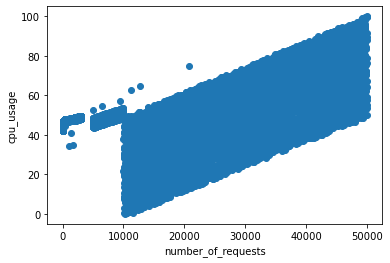

In [12]:
plt.scatter(train_data["number_of_requests"], train_data["cpu_usage"])
plt.xlabel('number_of_requests')
plt.ylabel('cpu_usage')


In [13]:
##  the number_of_errors does affect cpu_usage until about  a certain value afterwhich its constant

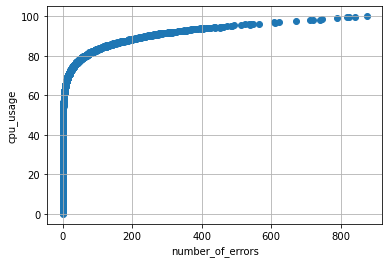

In [14]:
plt.scatter(train_data["number_of_errors"], train_data["cpu_usage"])
plt.xlabel('number_of_errors')
plt.ylabel('cpu_usage')
plt.grid(True)

In [15]:
## the response time seem to have low correlation and is almost random so i will remove it as a feature 

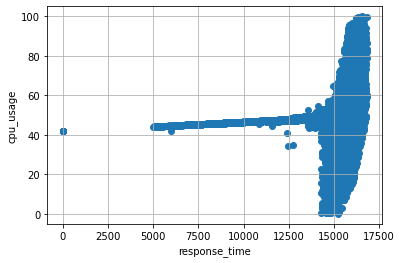

In [16]:
plt.scatter(train_data["response_time"], train_data["cpu_usage"])
plt.xlabel('response_time')
plt.ylabel('cpu_usage')
plt.grid(True)

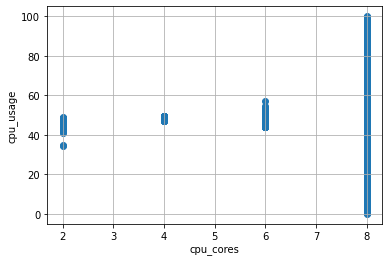

In [17]:
plt.scatter(train_data["cpu_cores"], train_data["cpu_usage"])
plt.xlabel('cpu_cores')
plt.ylabel('cpu_usage')
plt.grid(True)

In [18]:
train_data

,number_of_requests,number_of_errors,response_time,cpu_cores,cpu_usage
0,9758,0.0,14742.755324,6,48.498589
1,9967,2.0,14897.201621,6,53.355349
2,5210,1.0,14009.132817,6,46.573140
3,7361,1.0,14716.491537,6,46.624516
4,9667,0.0,15148.657690,6,49.455284
...,...,...,...,...,...
51596,9303,2.0,14376.052495,6,51.684143
51597,5945,1.0,14373.898084,6,47.571840
51598,6959,1.0,14768.549663,6,47.585932
51599,8274,0.0,14352.171497,6,48.178243


## Predictions

### scaling our data 

##### from the graphs it can be seen that our data is skewed and therefore we will scale 

In [55]:
x_train = train_data[['number_of_requests','number_of_errors']]
y_train = train_data.drop(['number_of_requests','number_of_errors','cpu_cores','response_time'], axis = 1)

x_test = train_data[['number_of_requests','number_of_errors']]
y_test = train_data.drop(['number_of_requests','number_of_errors','cpu_cores','response_time'], axis = 1)

In [57]:
sc = MinMaxScaler()
x_train_transformed = sc.fit_transform(x_train)
y_train_transformed = sc.fit_transform(y_train)

x_test_transformed = sc.fit_transform(x_test)
y_test_transformed = sc.fit_transform(y_test)

In [74]:
#VALIDATOING THE FIRST MODEL
model_LR=LinearRegression()
model_LR.fit(x_train_transformed, y_train_transformed)
prediction_LR =model_LR.predict(x_test_transformed) 

print(mean_absolute_error(y_test_transformed, prediction_LR))

0.024722229680147152


In [73]:
#VALIDATING THE SECOND MODEL
model_svm = svm.SVR()
model_svm.fit(x_train_transformed, y_train_transformed)
prediction_svm =model_svm.predict(x_test_transformed) 

print(mean_absolute_error(y_test_transformed, prediction_svm))


C:\Users\New User\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.06988404904827943


In [72]:
#VALIDATOING THE THIRD MODEL
model_RFR=RandomForestRegressor()
model_RFR.fit(x_train_transformed, y_train_transformed)
prediction_RFR =model_RFR.predict(x_test_transformed) 

print(mean_absolute_error(y_test_transformed, prediction_RFR))

C:\Users\NEWUSE~1\AppData\Local\Temp/ipykernel_7652/3827188970.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_RFR.fit(x_train_transformed, y_train_transformed)


0.003946464045331623


In [71]:
#VALIDATOING THE THIRD MODEL
model_XGB=XGBRegressor()
model_XGB.fit(x_train_transformed, y_train_transformed)
prediction_XGB =model_XGB.predict(x_test_transformed) 

print(mean_absolute_error (y_test_transformed, prediction_XGB))


0.00609192091895194


In [51]:
## model_RFR is the best for this case 